## Interpolación Espacial

### Objetivos

-   Calcular un variograma empírico

-   Ajustar un modelo de variograma

-   Interpolar utilizando tres métodos:

    -   Interpolación ponderada de distancia inversa (IDW)

    -   Kriging ordinario (OK)

    -   Kriging universal (UK)

-   Evaluar la precisión de la interpolación mediante la validación cruzada Leave-One-Out

In [2]:
library(sf)
library(stars)
library(gstat)
library(automap)

### Métodos de interpolación

Hay dos métodos de kriging de uso frecuente: Kriging ordinario (OK) y Kriging universal (UK). Sumando la interpolación ponderada de distancia inversa (IDW).

In [3]:
getwd()

[1] "C:/Users/AGPRES/Jupyter_Python/AGPRES/Datos_suelo/Script"

In [4]:
setwd(r"(C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Satelite\Sentinel2\Bandas\SHP)")

In [5]:
# Crear lista de SHP del directorio
lista_shp <- list.files(path = getwd(), pattern = '.*shp$')
lista_shp

[1] "SHP_Residuales_Al.shp"      "SHP_Residuales_Arcilla.shp"
 [3] "SHP_Residuales_Arena.shp"   "SHP_Residuales_BT.shp"     
 [5] "SHP_Residuales_Ca.shp"      "SHP_Residuales_CE.shp"     
 [7] "SHP_Residuales_CICe.shp"    "SHP_Residuales_K.shp"      
 [9] "SHP_Residuales_Limo.shp"    "SHP_Residuales_Mg.shp"     
[11] "SHP_Residuales_MO.shp"      "SHP_Residuales_N.shp"      
[13] "SHP_Residuales_P.shp"       "SHP_Residuales_pH.shp"     
[15] "SHP_Residuales_SAl.shp"

In [6]:
suelo = lista_shp[2]
suelo

[1] "SHP_Residuales_Arcilla.shp"

In [7]:
nchar(suelo)-4

[1] 22

In [8]:
name_suelo = substr(suelo, start = 5, stop = nchar(suelo) -4)
name_suelo

[1] "Residuales_Arcilla"

In [9]:
soil_eea <- st_read(suelo)

Reading layer `SHP_Residuales_Arcilla' from data source 
  `C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Satelite\Sentinel2\Bandas\SHP\SHP_Residuales_Arcilla.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 60 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 511953 ymin: 9055598 xmax: 513309 ymax: 9057120
Projected CRS: WGS 84 / UTM zone 18S


In [10]:
library(geojsonsf)

In [11]:
soil_eea$lst_rsd

[1]  -0.6941845   2.4384919   0.4541642   6.7555998   8.6671340  -4.2188243
 [7]   1.9108913  -3.3645450  -1.2699692   5.1688238  -1.9163017  12.2636293
[13]  13.8698390   1.8377860  -0.6919988   7.6186998   6.0370390   4.2393452
[19]   7.8363669   2.1168762  16.1720648   4.2362104   0.6327544   7.7896311
[25]   4.6400391   3.9439641   0.6977111   7.4399164  -6.6464902  -4.7331478
[31]  -7.1806904  -1.6381964  -3.3510528  -8.3344595 -10.2125745  -4.9839942
[37]  -0.8300893 -12.4076373  -2.7258307  -1.5846578  -9.6125226  -4.9230096
[43] -13.8043116   6.1202623   5.5264320  -0.0668264 -10.9181699  -1.3648883
[49] -10.4250816   4.7021542  -1.8527718  19.4969033   6.5539929  -2.1293773
[55]  -3.6461589  -5.2533626  -6.9689916  -2.4428745  -1.2719752 -15.7664599

Para contar con una grilla usaremos un DEM de nuestro área de interés.

In [12]:
min_valor <- min(soil_eea$lst_rsd)
max_valor <- max(soil_eea$lst_rsd)

In [13]:
dem <- read_stars(r"(C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Satelite\Mde\ALOS_MDE_10m.tif)")

In [14]:
dem

stars object with 2 dimensions and 1 attribute
attribute(s):
                  Min. 1st Qu. Median     Mean 3rd Qu. Max.
ALOS_MDE_10m.tif   201     218    224 223.8333     229  251
dimension(s):
  from  to  offset delta                refsys point x/y
x    1 461  510245    10 WGS 84 / UTM zone 18S FALSE [x]
y    1 386 9058366   -10 WGS 84 / UTM zone 18S FALSE [y]

In [15]:
borders <- st_read(r"(C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Shp\CE_Campo_Verde.shp)")

Reading layer `CE_Campo_Verde' from data source 
  `C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Shp\CE_Campo_Verde.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 8 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 511873.1 ymin: 9055542 xmax: 513451.8 ymax: 9057244
Projected CRS: WGS 84 / UTM zone 18S


In [16]:
borders_buffer <- st_buffer(st_geometry(st_as_sf(borders)), dist = 30)

In [17]:
grid <-  st_as_sfc(st_bbox(borders_buffer))
grid <-  st_as_stars(grid, dx = 10, dy = 10)
dem <-  st_warp(src = dem, grid, method = "average", use_gdal = TRUE)
dem <-  dem[borders_buffer]
names(dem) = "elev_10m"

Warning message in st_warp(src = dem, grid, method = "average", use_gdal = TRUE):
"no_data_value not set: missing values will appear as zero values"


A continuación, extraemos los valores de elevación y creamos un subconjunto de aquellas estaciones que coincidan con el ráster:

In [18]:
soil_eea = st_join(soil_eea, st_as_sf(dem))

soil_eea = soil_eea[!is.na(soil_eea$lst_rsd), ]

Ahora me puedes mostrar el ráster de elevación dem y la capa de puntos sobre suelos:

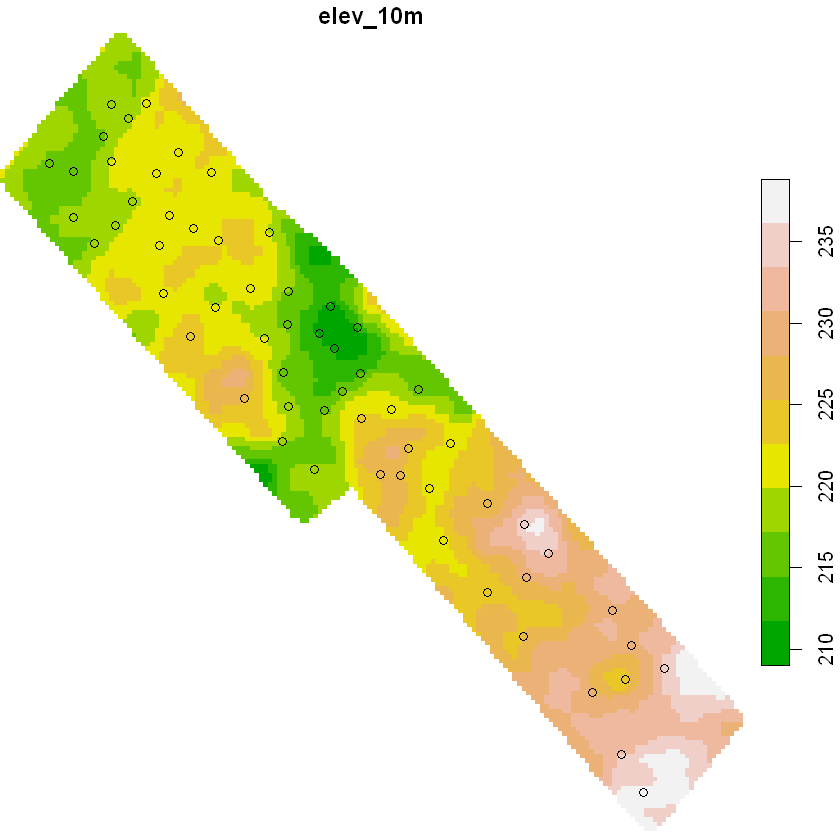

In [19]:
plot(dem, breaks = "equal", col = terrain.colors(11), reset = FALSE)
plot(st_geometry(soil_eea), add = TRUE)

### Kriging Ordinario

Los métodos kriging requieren un modelo de variograma. El modelo de variograma es una forma objetiva de cuantificar el patrón de autocorrelación en los datos y asignar pesos en consecuencia al hacer predicciones.

Como primer paso, podemos calcular y examinar el variograma empírico utilizando la función de variograma. La función requiere dos argumentos:

-   `formula`---Specifies the **dependent variable** and the **covariates**, just like in `gstat`

-   `data`---The **point** layer with the dependent variable and covariates as point attributes

Por ejemplo, la siguiente expresión calcula el variograma empírico de **pH**, sin covariables.

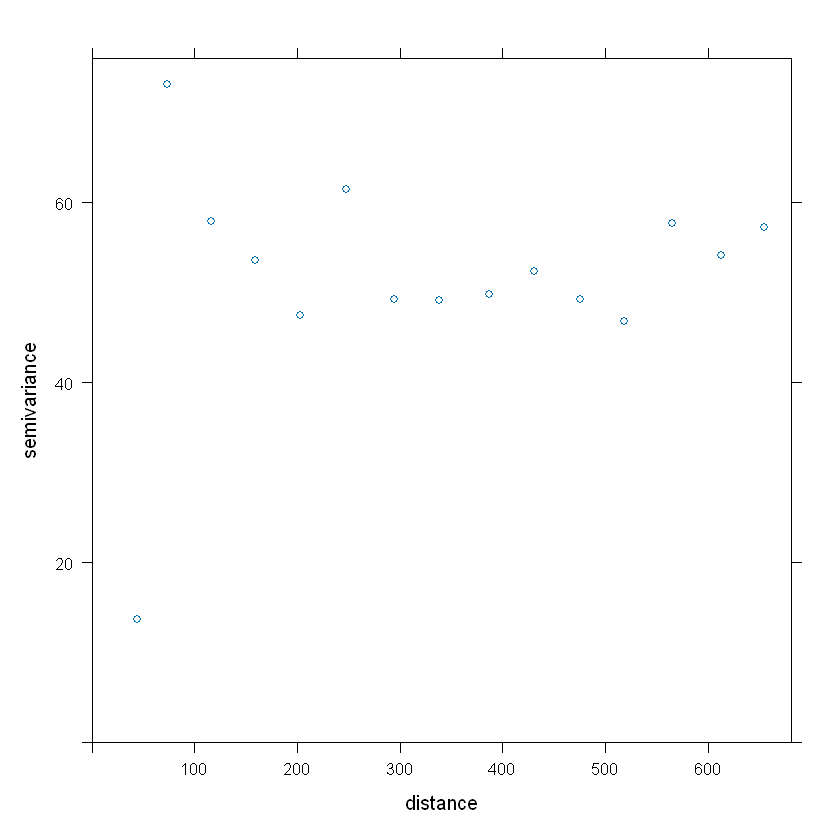

In [20]:
v_emp_ok = variogram(soil_eea$lst_rsd ~ 1, soil_eea)

plot(v_emp_ok)

Hay varias formas de ajustar un modelo de variograma a un variograma empírico. Usaremos el más simple: ajuste automático usando la función autofitVariogram del paquete `automap`:

In [21]:
library(automap)
v_mod_ok = autofitVariogram(soil_eea$lst_rsd ~ 1, as(soil_eea, "Spatial"))

La función elige el tipo de modelo que mejor se ajusta y también ajusta sus parámetros. Tenga en cuenta que la función `autofitVariogram` no funciona en objetos *sf*, razón por la cual convertimos el objeto en un `SpatialPointsDataFrame` (paquete sp).\
\
El modelo ajustado se puede trazar con plot:

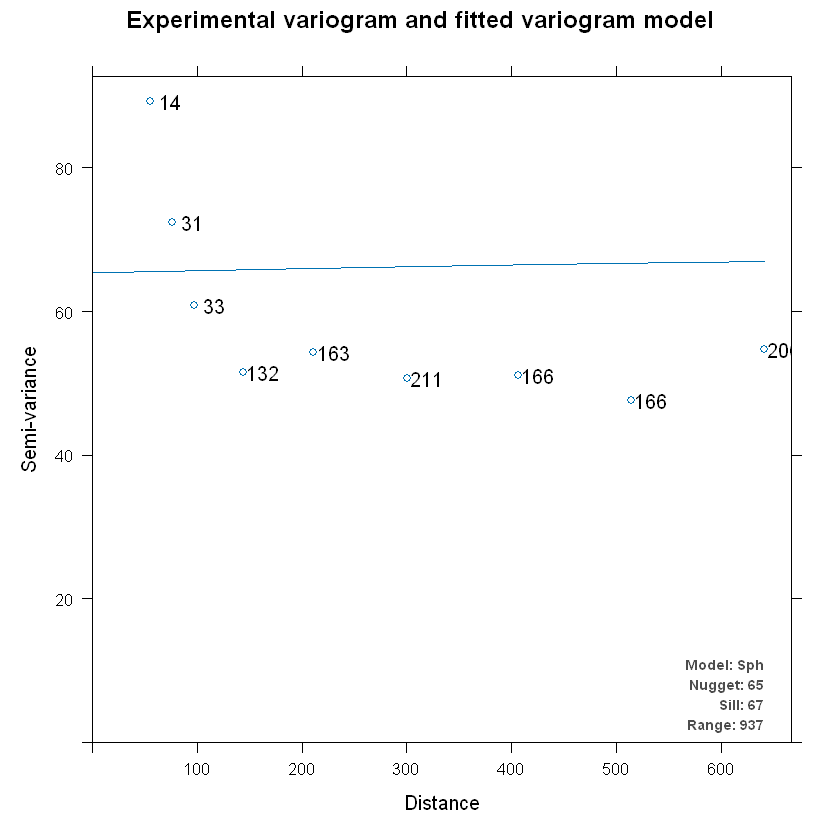

In [22]:
plot(v_mod_ok)

El objeto resultante es en realidad una lista con varios componentes, incluido el variograma empírico y el modelo de variograma ajustado. El componente `$var_model` del objeto resultante contiene el modelo real:

In [23]:
v_mod_ok$var_model

,model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Nug,65.389198,0.0000,0,0,0,0,1,1
2,Sph,1.801031,936.8049,0,0,0,0,1,1


Luego, el modelo de variograma se puede pasar a la función **gstat** y podemos continuar con la interpolación de Kriging ordinario:

In [24]:
g2 = gstat(formula = soil_eea$lst_rsd ~ 1, model = v_mod_ok$var_model, data = soil_eea)
z = predict(g2, dem)

[using ordinary kriging]


In [25]:
name_suelo

[1] "Residuales_Arcilla"

In [26]:
#subdividiremos el atributo de valores predecidos y lo renombraremos
z = z["var1.pred",,]
names(z) = name_suelo

In [27]:
# Crear una carpeta con el nombre ID imagen y agregar texto
out_dir <- paste(getwd(), '//Raster_residuo', sep='')
suppressWarnings(dir.create(out_dir))

In [28]:
# Exportando el raster
write_stars(z, paste(out_dir,"/Residuo_",name_suelo,".tif",sep = ""))

Las predicciones de Kriging Ordinario se muestran en la siguiente figura:

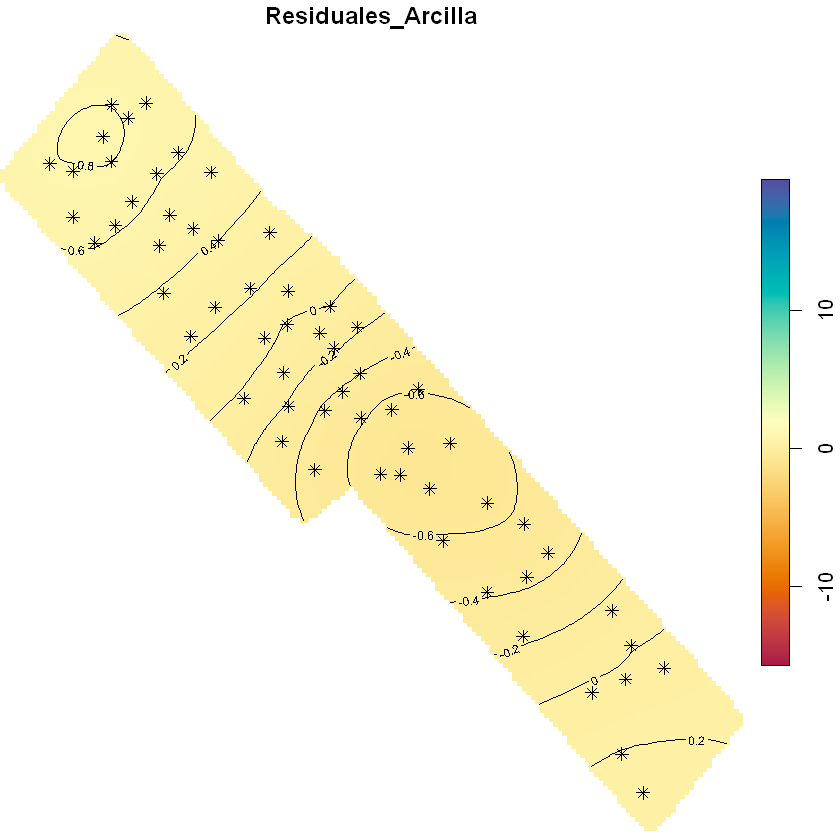

In [29]:
b = seq(min_valor, max_valor, 0.001)
plot(z, breaks = b, col = hcl.colors(length(b)-1, "Spectral"), reset = FALSE)
plot(st_geometry(soil_eea), pch = 8, add = TRUE)
contour(z, breaks = b, add = TRUE)

In [30]:
for (i in 1:length(lista_shp)){
    name_suelo = substr(lista_shp[i], start = 5, stop = nchar(suelo) -4)
    soil_eea <- st_read(lista_shp[i])
    min_valor <- min(soil_eea$lst_rsd)
    max_valor <- max(soil_eea$lst_rsd)
    borders_buffer <- st_buffer(st_geometry(st_as_sf(borders)), dist = 30)
    grid <-  st_as_sfc(st_bbox(borders_buffer))
    grid <-  st_as_stars(grid, dx = 10, dy = 10)
    dem <-  st_warp(src = dem, grid, method = "average", use_gdal = TRUE)
    dem <-  dem[borders_buffer]
    names(dem) = "elev_10m"
    soil_eea = st_join(soil_eea, st_as_sf(dem))
    soil_eea = soil_eea[!is.na(soil_eea$lst_rsd), ]
    v_emp_ok = variogram(soil_eea$lst_rsd ~ 1, soil_eea)
    g2 = gstat(formula = soil_eea$lst_rsd ~ 1, model = v_mod_ok$var_model, data = soil_eea)
    z = predict(g2, dem)
    z = z["var1.pred",,]
    names(z) = name_suelo
    # Crear una carpeta con el nombre ID imagen y agregar texto
    out_dir <- paste(getwd(), '//Raster_residuo', sep='')
    suppressWarnings(dir.create(out_dir))
    # Exportando el raster
    write_stars(z, paste(out_dir,"/Residuo_",name_suelo,".tif",sep = ""))
    }

Reading layer `SHP_Residuales_Al' from data source 
  `C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Satelite\Sentinel2\Bandas\SHP\SHP_Residuales_Al.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 60 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 511953 ymin: 9055598 xmax: 513309 ymax: 9057120
Projected CRS: WGS 84 / UTM zone 18S


Warning message in st_warp(src = dem, grid, method = "average", use_gdal = TRUE):
"no_data_value not set: missing values will appear as zero values"


[using ordinary kriging]
Reading layer `SHP_Residuales_Arcilla' from data source 
  `C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Satelite\Sentinel2\Bandas\SHP\SHP_Residuales_Arcilla.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 60 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 511953 ymin: 9055598 xmax: 513309 ymax: 9057120
Projected CRS: WGS 84 / UTM zone 18S


Warning message in st_warp(src = dem, grid, method = "average", use_gdal = TRUE):
"no_data_value not set: missing values will appear as zero values"


[using ordinary kriging]
Reading layer `SHP_Residuales_Arena' from data source 
  `C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Satelite\Sentinel2\Bandas\SHP\SHP_Residuales_Arena.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 60 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 511953 ymin: 9055598 xmax: 513309 ymax: 9057120
Projected CRS: WGS 84 / UTM zone 18S


Warning message in st_warp(src = dem, grid, method = "average", use_gdal = TRUE):
"no_data_value not set: missing values will appear as zero values"


[using ordinary kriging]
Reading layer `SHP_Residuales_BT' from data source 
  `C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Satelite\Sentinel2\Bandas\SHP\SHP_Residuales_BT.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 60 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 511953 ymin: 9055598 xmax: 513309 ymax: 9057120
Projected CRS: WGS 84 / UTM zone 18S


Warning message in st_warp(src = dem, grid, method = "average", use_gdal = TRUE):
"no_data_value not set: missing values will appear as zero values"


[using ordinary kriging]
Reading layer `SHP_Residuales_Ca' from data source 
  `C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Satelite\Sentinel2\Bandas\SHP\SHP_Residuales_Ca.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 60 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 511953 ymin: 9055598 xmax: 513309 ymax: 9057120
Projected CRS: WGS 84 / UTM zone 18S


Warning message in st_warp(src = dem, grid, method = "average", use_gdal = TRUE):
"no_data_value not set: missing values will appear as zero values"


[using ordinary kriging]
Reading layer `SHP_Residuales_CE' from data source 
  `C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Satelite\Sentinel2\Bandas\SHP\SHP_Residuales_CE.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 60 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 511953 ymin: 9055598 xmax: 513309 ymax: 9057120
Projected CRS: WGS 84 / UTM zone 18S


Warning message in st_warp(src = dem, grid, method = "average", use_gdal = TRUE):
"no_data_value not set: missing values will appear as zero values"


[using ordinary kriging]
Reading layer `SHP_Residuales_CICe' from data source 
  `C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Satelite\Sentinel2\Bandas\SHP\SHP_Residuales_CICe.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 60 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 511953 ymin: 9055598 xmax: 513309 ymax: 9057120
Projected CRS: WGS 84 / UTM zone 18S


Warning message in st_warp(src = dem, grid, method = "average", use_gdal = TRUE):
"no_data_value not set: missing values will appear as zero values"


[using ordinary kriging]
Reading layer `SHP_Residuales_K' from data source 
  `C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Satelite\Sentinel2\Bandas\SHP\SHP_Residuales_K.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 60 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 511953 ymin: 9055598 xmax: 513309 ymax: 9057120
Projected CRS: WGS 84 / UTM zone 18S


Warning message in st_warp(src = dem, grid, method = "average", use_gdal = TRUE):
"no_data_value not set: missing values will appear as zero values"


[using ordinary kriging]
Reading layer `SHP_Residuales_Limo' from data source 
  `C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Satelite\Sentinel2\Bandas\SHP\SHP_Residuales_Limo.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 60 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 511953 ymin: 9055598 xmax: 513309 ymax: 9057120
Projected CRS: WGS 84 / UTM zone 18S


Warning message in st_warp(src = dem, grid, method = "average", use_gdal = TRUE):
"no_data_value not set: missing values will appear as zero values"


[using ordinary kriging]
Reading layer `SHP_Residuales_Mg' from data source 
  `C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Satelite\Sentinel2\Bandas\SHP\SHP_Residuales_Mg.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 60 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 511953 ymin: 9055598 xmax: 513309 ymax: 9057120
Projected CRS: WGS 84 / UTM zone 18S


Warning message in st_warp(src = dem, grid, method = "average", use_gdal = TRUE):
"no_data_value not set: missing values will appear as zero values"


[using ordinary kriging]
Reading layer `SHP_Residuales_MO' from data source 
  `C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Satelite\Sentinel2\Bandas\SHP\SHP_Residuales_MO.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 60 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 511953 ymin: 9055598 xmax: 513309 ymax: 9057120
Projected CRS: WGS 84 / UTM zone 18S


Warning message in st_warp(src = dem, grid, method = "average", use_gdal = TRUE):
"no_data_value not set: missing values will appear as zero values"


[using ordinary kriging]
Reading layer `SHP_Residuales_N' from data source 
  `C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Satelite\Sentinel2\Bandas\SHP\SHP_Residuales_N.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 60 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 511953 ymin: 9055598 xmax: 513309 ymax: 9057120
Projected CRS: WGS 84 / UTM zone 18S


Warning message in st_warp(src = dem, grid, method = "average", use_gdal = TRUE):
"no_data_value not set: missing values will appear as zero values"


[using ordinary kriging]
Reading layer `SHP_Residuales_P' from data source 
  `C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Satelite\Sentinel2\Bandas\SHP\SHP_Residuales_P.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 60 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 511953 ymin: 9055598 xmax: 513309 ymax: 9057120
Projected CRS: WGS 84 / UTM zone 18S


Warning message in st_warp(src = dem, grid, method = "average", use_gdal = TRUE):
"no_data_value not set: missing values will appear as zero values"


[using ordinary kriging]
Reading layer `SHP_Residuales_pH' from data source 
  `C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Satelite\Sentinel2\Bandas\SHP\SHP_Residuales_pH.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 60 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 511953 ymin: 9055598 xmax: 513309 ymax: 9057120
Projected CRS: WGS 84 / UTM zone 18S


Warning message in st_warp(src = dem, grid, method = "average", use_gdal = TRUE):
"no_data_value not set: missing values will appear as zero values"


[using ordinary kriging]
Reading layer `SHP_Residuales_SAl' from data source 
  `C:\Users\AGPRES\Jupyter_Python\AGPRES\Datos_suelo\Satelite\Sentinel2\Bandas\SHP\SHP_Residuales_SAl.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 60 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 511953 ymin: 9055598 xmax: 513309 ymax: 9057120
Projected CRS: WGS 84 / UTM zone 18S


Warning message in st_warp(src = dem, grid, method = "average", use_gdal = TRUE):
"no_data_value not set: missing values will appear as zero values"


[using ordinary kriging]
